In [353]:
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn import tree

In [354]:
phone_data = pd.read_csv('user_behavior_preprocessed.csv')

phone_data

,User ID,Operating System,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,Gender,User Behavior Class,Device Model_google pixel 5,Device Model_iphone 12,Device Model_oneplus 9,Device Model_samsung galaxy s21,Device Model_xiaomi mi 11
0,1,1,393,6.4,1872,67,1122,40,0,4,True,False,False,False,False
1,2,1,268,4.7,1331,42,944,47,1,3,False,False,True,False,False
2,3,1,154,4.0,761,32,322,42,0,2,False,False,False,False,True
3,4,1,239,4.8,1676,56,871,20,0,3,True,False,False,False,False
4,5,0,187,4.3,1367,58,988,31,1,3,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,696,0,92,3.9,1082,26,381,22,0,2,False,True,False,False,False
696,697,1,316,6.8,1965,68,1201,59,0,4,False,False,False,False,True
697,698,1,99,3.1,942,22,457,50,1,2,True,False,False,False,False
698,699,1,62,1.7,431,13,224,44,0,1,False,False,False,True,False


# Why KNN and Decision Trees?

The target variable, User Behavior Class, is strictly categorical, ranging from 1-5 denoting how heavy of a phone user the individual is. The metrics used are prone to multicolinearity (app usage time and screen time have a high correlation, supported both empirically and logically), and as such, it is a priority from the onset to establish an effective web of predictability not too influenced by the high likelihood of inter-correlation. Compromising with our desire to predict a categorical value, KNN as well as decision tress offer the best balance of stability and effectiveness in this use case, as logistic regression would be ill-advised when the data is so tightly correlated.

# High-Level Visualization

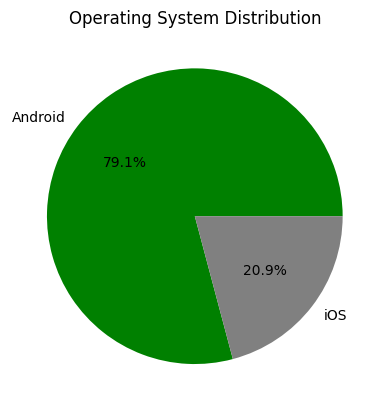

In [355]:
# OS Distribution

os_distribution = phone_data['Operating System'].value_counts()

custom_labels = ['Android', 'iOS']
plt.pie(os_distribution, labels=custom_labels, autopct='%1.1f%%', colors=['green','gray']) # autopct rounds
plt.title('Operating System Distribution')
plt.show()

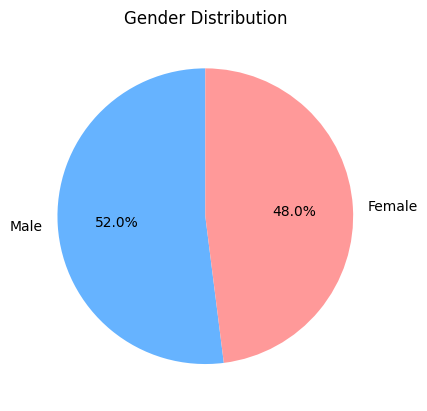

In [356]:
# Gender Distribution

gender_distribution = phone_data['Gender'].value_counts()

custom_labels = ['Male', 'Female']
plt.pie(gender_distribution, labels = custom_labels, autopct='%1.1f%%', startangle = 90, colors=['#66b3ff','#ff9999']) #autopct rounds
plt.title('Gender Distribution')
plt.show()

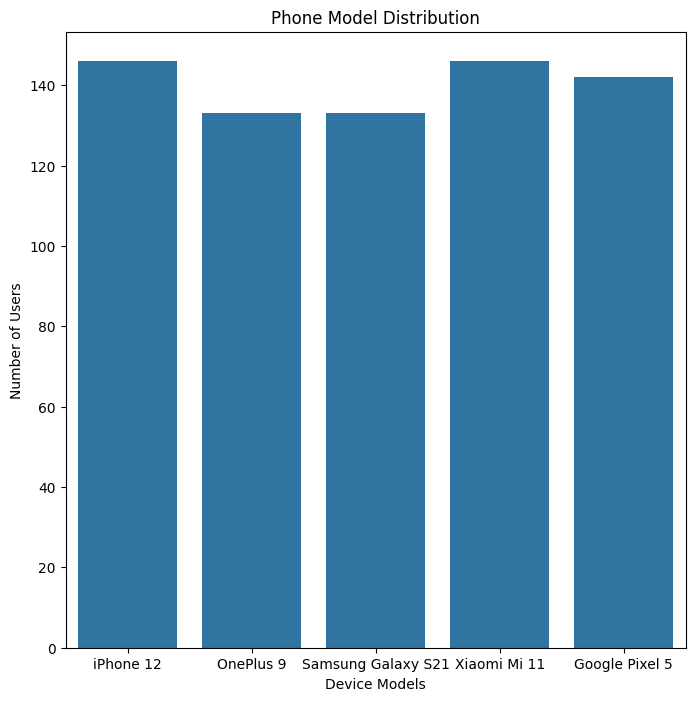

In [357]:
# Because I one-hot encoded the device models, I'm going to manually tally the columns and sum them up to get my representative data.
device_tally = {
    "iPhone 12" : phone_data["Device Model_iphone 12"].sum(),
    "OnePlus 9" : phone_data["Device Model_oneplus 9"].sum(),
    "Samsung Galaxy S21" : phone_data["Device Model_samsung galaxy s21"].sum(),
    "Xiaomi Mi 11" : phone_data["Device Model_xiaomi mi 11"].sum(),
    "Google Pixel 5" : phone_data["Device Model_google pixel 5"].sum()
}

# Create a bar graph from the tallied counts
plt.figure(figsize= (8,8))
sns.barplot(data = device_tally)
plt.xlabel("Device Models")
plt.ylabel("Number of Users")
plt.title("Phone Model Distribution")
plt.show()

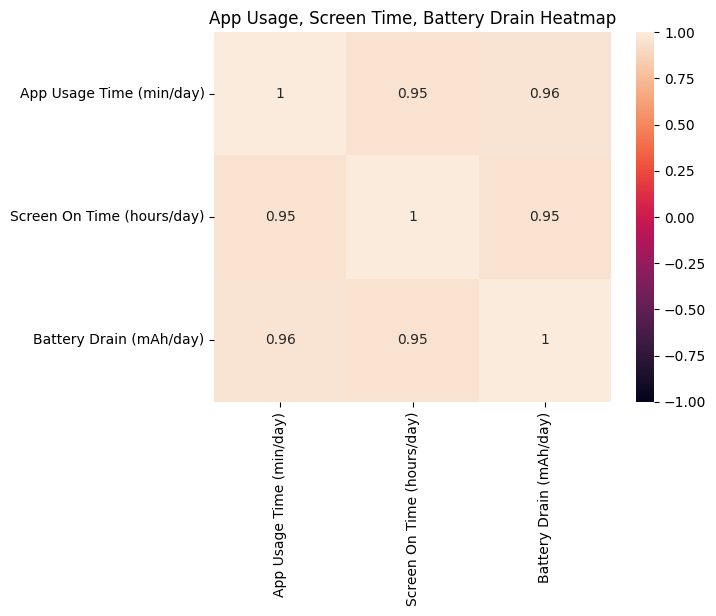

In [358]:
# Visual to demonstrate the strong multicolinearity I hypothesized earlier
data = phone_data[['App Usage Time (min/day)', 'Screen On Time (hours/day)', 'Battery Drain (mAh/day)']]

correlation_matrix = data.corr()

plt.figure()
sns.heatmap(correlation_matrix, annot=True, vmin=-1, vmax=1)

# Customize labels and title
plt.title('App Usage, Screen Time, Battery Drain Heatmap')
plt.show()

### Takeaways

Android constitutes 80% of the phone market, even though the iPhone 12 is the second-best selling phone; this makes sense, though, as the 4 competitors all use Android and collectively have sold more.
The gender distribution is fairly equal, which is also expected considering the ubiquity of mobile phones. 

The proverbial final blow, however, is the final visual, which demonstrates a strong correlation between three important variables, app usage time, screen time, and battery drain. Of course, there are other variables which are strongly correlated as well, but this is sufficient to illustrate my point about multicolinearity.

# KNN

In [359]:
# First, we need to establish our train-test split as well as our variables
X = phone_data.drop(columns = ['User Behavior Class', 'User ID'], axis = 1)
y = phone_data['User Behavior Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Find the optimal K value
def optimalNeighbors(X_train, X_test, y_train, y_test) -> int:
    maxScore = 0
    maxK = 1

    for currK in range(1, 5):
        knn = KNeighborsClassifier(n_neighbors = currK)
        knn.fit(X_train, y_train)
        knnPred = knn.predict(X_test)
        currScore = knn.score(X_test, y_test)
        if (currScore > maxScore):
            maxScore = currScore
            maxK = currK

    return maxK

# Establish K
k = optimalNeighbors(X_train, X_test, y_train, y_test)

# Train the KNN model using the optimal number of neighbors found above
knn = KNeighborsClassifier(n_neighbors = k)
knn.fit(X_train, y_train)

# Predict
kPred = knn.predict(X_test)
print(knn.score(X_test, y_test))

1.0


# Decision Trees

In [360]:
# Decision tree classifier
# Deep and complex trees tend to overfit, so we want to generalize and have reasonably simple trees, as much as possible.
model = tree.DecisionTreeClassifier(max_depth = 5, random_state = 42)

In [361]:
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [362]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        46
           2       0.97      1.00      0.99        34
           3       1.00      0.98      0.99        50
           4       1.00      1.00      1.00        47
           5       1.00      1.00      1.00        33

    accuracy                           1.00       210
   macro avg       0.99      1.00      1.00       210
weighted avg       1.00      1.00      1.00       210



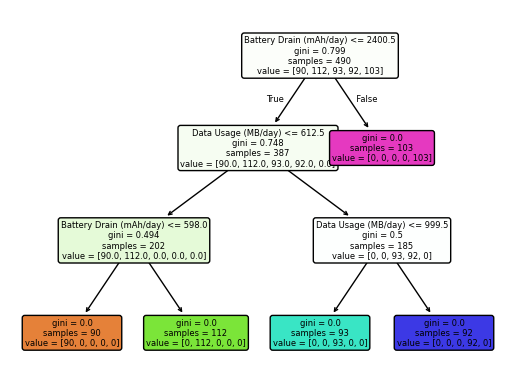

In [363]:
import matplotlib.pyplot as plt
tree.plot_tree(model, feature_names = list(X.columns), filled = True, fontsize = 6, rounded = True)

plt.show()